In [22]:
import pandas as pd
import matplotlib.pyplot as plt

In [23]:
# paths (workspace)
sales_path = "/Users/luciapiron/Desktop/machine learning course/TeamCPH/data/umsatzdaten_gekuerzt.csv"
wetter_path = "/Users/luciapiron/Desktop/machine learning course/TeamCPH/data/wetter.csv"
kiwo_path = "/Users/luciapiron/Desktop/machine learning course/TeamCPH/data/kiwo.csv"
holidays_path = "/Users/luciapiron/Desktop/machine learning course/TeamCPH/data/school_holidays_SH.csv"

In [24]:
# load sales and aggregate to daily total
sales = pd.read_csv(sales_path, parse_dates=["Datum"])
sales_daily = sales.groupby("Datum", as_index=False)["Umsatz"].sum()

# load weather and kieler-week flags
wetter = pd.read_csv(wetter_path, parse_dates=["Datum"])
kiwo = pd.read_csv(kiwo_path, parse_dates=["Datum"])
holidays = pd.read_csv(holidays_path, parse_dates=["Datum"])

In [25]:
# merge: sales <- weather <- kiwo
merged = sales_daily.merge(wetter, on="Datum", how="left")
merged = merged.merge(kiwo, on="Datum", how="left")
merged = merged.merge(holidays, on="Datum", how="left")

In [26]:
# fill missing KielerWoche as 0 (not festival) and sort
merged["KielerWoche"] = merged["KielerWoche"].fillna(0).astype(int)
merged = merged.sort_values("Datum").reset_index(drop=True)

# extract year-month and aggregate
merged["YearMonth"] = merged["Datum"].dt.to_period("M")

# group by month: sum revenue and count KielerWoche days
monthly = merged.groupby("YearMonth").agg({
    "Umsatz": "sum",
    "KielerWoche": "sum"
}).reset_index()

# convert YearMonth back to timestamp for plotting
monthly["YearMonth"] = monthly["YearMonth"].dt.to_timestamp()



# result
print(merged.head())
# optionally save
# merged.to_csv("/workspaces/TeamCPH/merged_daily.csv", index=False)

       Datum       Umsatz  Bewoelkung  Temperatur  Windgeschwindigkeit  \
0 2013-07-01  1269.249107         6.0     17.8375                 15.0   
1 2013-07-02  1430.008397         3.0     17.3125                 10.0   
2 2013-07-03  1124.274894         7.0     21.0750                  6.0   
3 2013-07-04  1184.309567         7.0     18.8500                  7.0   
4 2013-07-05  1288.023060         5.0     19.9750                 12.0   

   Wettercode  KielerWoche  holiday YearMonth  
0        20.0            0        1   2013-07  
1         NaN            0        1   2013-07  
2        61.0            0        1   2013-07  
3        20.0            0        1   2013-07  
4         NaN            0        1   2013-07  


In [29]:
#saving the merged file as csv
merged.to_csv("merged_daily.csv", index=False)
print("File saved successfully!")

File saved successfully!


In [ ]:
# making the data in datum column datetime data
merged["Datum"] = pd.to_datetime(merged["Datum"])

In [ ]:
#verifying that it worked
print(merged["Datum"].dtype)
print(merged.info())

datetime64[ns]
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1819 entries, 0 to 1818
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   Datum                1819 non-null   datetime64[ns]
 1   Umsatz               1819 non-null   float64       
 2   Bewoelkung           1807 non-null   float64       
 3   Temperatur           1816 non-null   float64       
 4   Windgeschwindigkeit  1816 non-null   float64       
 5   Wettercode           1360 non-null   float64       
 6   KielerWoche          1819 non-null   int64         
 7   holiday              1819 non-null   int64         
 8   YearMonth            1819 non-null   period[M]     
dtypes: datetime64[ns](1), float64(5), int64(2), period[M](1)
memory usage: 128.0 KB
None


In [30]:
#changing column names to English
merged.rename(columns={'Datum': 'Date'}, inplace=True)
merged.rename(columns={'Umsatz': 'Revenue'}, inplace=True)
merged.rename(columns={'Bewoelkung': 'CloudCover'}, inplace=True)
merged.rename(columns={'Temperatur': 'Temperature'}, inplace=True)
merged.rename(columns={'Windgeschwindigkeit': 'WindSpeed'}, inplace=True)
merged.rename(columns={'Wettercode': 'WeatherCode'}, inplace=True)
merged.rename(columns={'KielerWoche': 'KielerWeek'}, inplace=True)
merged.rename(columns={'holiday': 'Holiday'}, inplace=True)
print(merged.head())

        Date      Revenue  CloudCover  Temperature  WindSpeed  WeatherCode  \
0 2013-07-01  1269.249107         6.0      17.8375       15.0         20.0   
1 2013-07-02  1430.008397         3.0      17.3125       10.0          NaN   
2 2013-07-03  1124.274894         7.0      21.0750        6.0         61.0   
3 2013-07-04  1184.309567         7.0      18.8500        7.0         20.0   
4 2013-07-05  1288.023060         5.0      19.9750       12.0          NaN   

   KielerWeek  Holiday YearMonth  
0           0        1   2013-07  
1           0        1   2013-07  
2           0        1   2013-07  
3           0        1   2013-07  
4           0        1   2013-07  


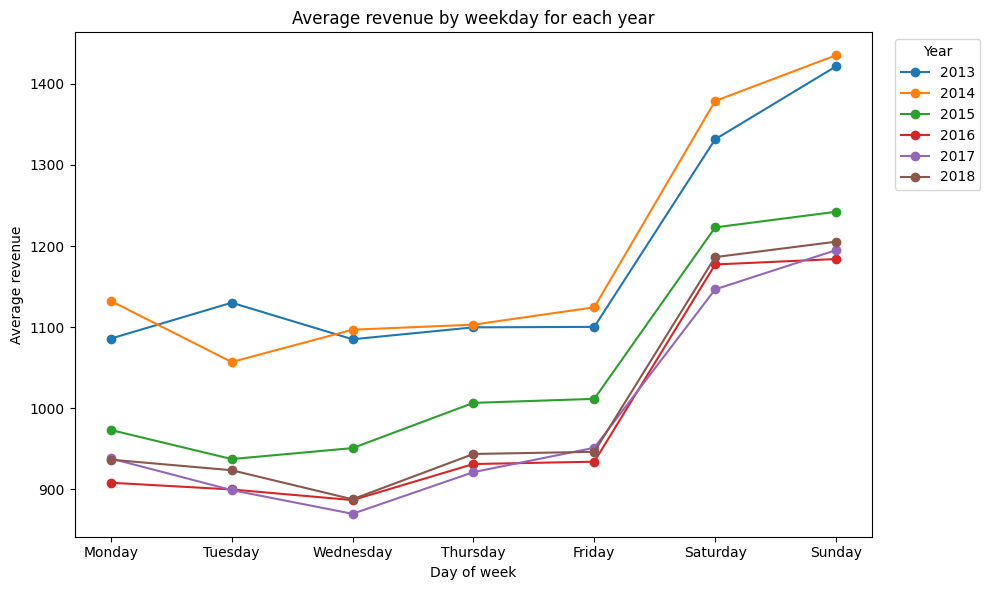

In [31]:
#creating a graph that shows the average revenue per day over time

# compute and plot average revenue by weekday for each year
merged['Date'] = pd.to_datetime(merged.get('Date', merged.get('Datum')))
merged['Revenue'] = pd.to_numeric(merged.get('Revenue', merged.get('Umsatz')), errors='coerce')

# extract year and weekday name
merged['Year'] = merged['Date'].dt.year
merged['Weekday'] = merged['Date'].dt.day_name()

# ensure weekday order Mon..Sun
weekday_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

# pivot: rows = Year, columns = Weekday
pivot = merged.groupby(['Year', 'Weekday'])['Revenue'].mean().unstack(level=1)
pivot = pivot.reindex(columns=weekday_order)  # order columns

import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(10,6))
for year in pivot.index:
    ax.plot(weekday_order, pivot.loc[year, weekday_order], marker='o', label=str(year))

ax.set_xlabel('Day of week')
ax.set_ylabel('Average revenue')
ax.set_title('Average revenue by weekday for each year')
ax.legend(title='Year', bbox_to_anchor=(1.02, 1), loc='upper left')
plt.tight_layout()
plt.show()

/var/folders/n8/b7lk16f91c514pclfv3qy2300000gn/T/ipykernel_22358/1699122768.py:31: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(weekday_order, rotation=45)
/var/folders/n8/b7lk16f91c514pclfv3qy2300000gn/T/ipykernel_22358/1699122768.py:31: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(weekday_order, rotation=45)


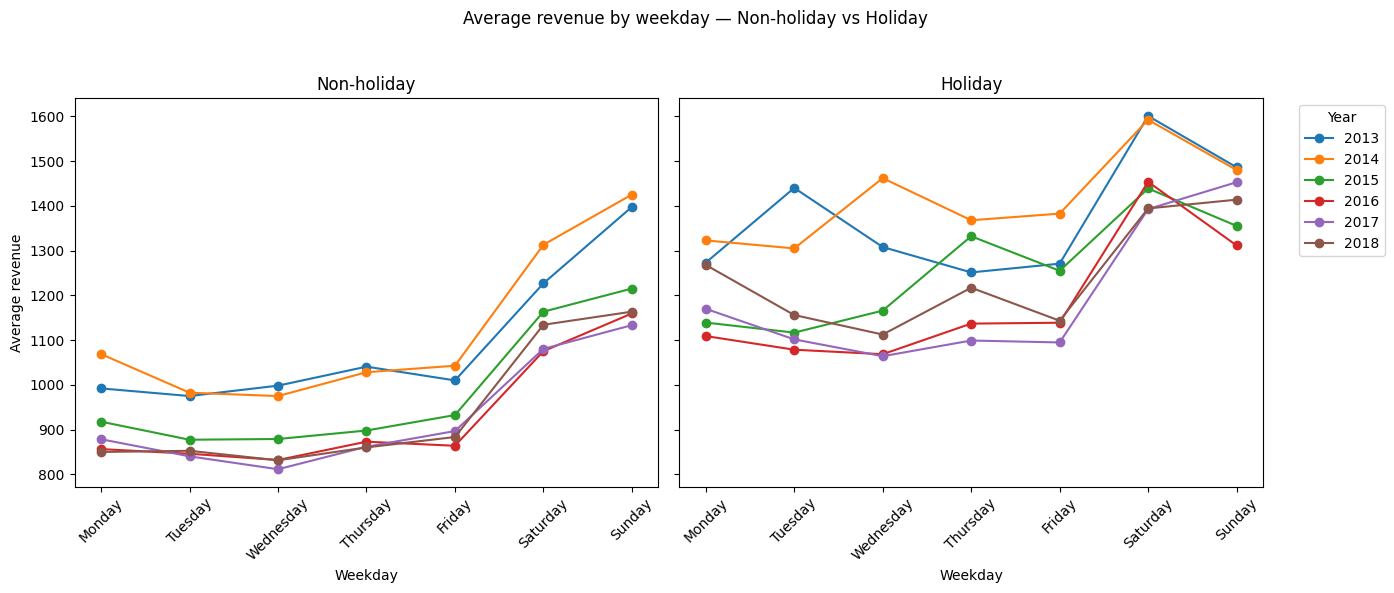

In [32]:
#creating a graph showing the relationship between revenue and school holidays

# plot average revenue by weekday split by holiday flag
merged['Date'] = pd.to_datetime(merged.get('Date', merged.get('Datum')))
merged['Revenue'] = pd.to_numeric(merged.get('Revenue', merged.get('Umsatz')), errors='coerce')

# ensure holiday column exists (handles 'holiday' or 'Holiday')
merged['HolidayFlag'] = merged.get('Holiday', merged.get('holiday'))

# extract year and weekday
merged['Year'] = merged['Date'].dt.year
merged['Weekday'] = merged['Date'].dt.day_name()
weekday_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

# group average revenue by Year, Weekday, HolidayFlag
grouped = merged.groupby(['Year', 'Weekday', 'HolidayFlag'])['Revenue'].mean().reset_index()

import matplotlib.pyplot as plt
fig, axes = plt.subplots(1, 2, figsize=(14,6), sharey=True)
for ax, flag, title in zip(axes, [0,1], ['Non-holiday', 'Holiday']):
    df_flag = grouped[grouped['HolidayFlag']==flag]
    if df_flag.empty:
        ax.text(0.5, 0.5, f'No data for {title}', ha='center')
        ax.set_title(title)
        continue
    pivot = df_flag.pivot(index='Year', columns='Weekday', values='Revenue').reindex(columns=weekday_order)
    for year in pivot.index:
        ax.plot(weekday_order, pivot.loc[year, weekday_order], marker='o', label=str(year))
    ax.set_title(title)
    ax.set_xlabel('Weekday')
    ax.set_xticklabels(weekday_order, rotation=45)
axes[0].set_ylabel('Average revenue')
axes[1].legend(title='Year', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.suptitle('Average revenue by weekday — Non-holiday vs Holiday')
plt.tight_layout(rect=[0,0,1,0.95])
plt.show()

In [37]:
# creating parameters like "low" "medium" "high" for temperature 

#FIRST OF ALL: CHECKING THE MIN AND MAX FOR EVERY MONTH

# ensure date and temperature columns exist and have correct types
merged['Date'] = pd.to_datetime(merged.get('Date', merged.get('Datum')))
merged['Temperature'] = pd.to_numeric(merged.get('Temperature', merged.get('Temperatur')), errors='coerce')

# 1) Lowest and highest temperature for each month of the year (Jan..Dec) aggregated across all years
merged['MonthName'] = merged['Date'].dt.month_name()
month_order = ['January','February','March','April','May','June','July','August','September','October','November','December']
monthly_min_max = merged.groupby('MonthName')['Temperature'].agg(min='min', max='max').reindex(month_order)
print("Min / Max temperature by month (all years):")
print(monthly_min_max)

# 2) If you want month-by-month per year (year-month)
yr_month = merged.groupby(merged['Date'].dt.to_period('M'))['Temperature'].agg(min='min', max='max').reset_index()
yr_month['YearMonth'] = yr_month['Date'].dt.to_timestamp()
yr_month = yr_month[['YearMonth','min','max']]
print("\nMin / Max temperature by year-month:")
print(yr_month.head(24))  # show first 24 rows

Min / Max temperature by month (all years):
               min      max
MonthName                  
January    -8.4750  11.6000
February   -6.1375  11.5000
March      -4.9625  19.7500
April       2.5000  24.3750
May         8.2500  26.8625
June       11.5625  27.8750
July       14.0000  31.2875
August     13.8750  31.4375
September  11.5750  27.8750
October     7.3750  20.0000
November    0.0000  16.5000
December   -3.0000  12.5000

Min / Max temperature by year-month:
    YearMonth      min      max
0  2013-07-01  17.3125  27.2625
1  2013-08-01  16.3875  31.4375
2  2013-09-01  11.5750  24.7000
3  2013-10-01   9.0750  17.6750
4  2013-11-01   2.3125  10.7000
5  2013-12-01   1.0000  11.4375
6  2014-01-01  -8.4750  10.4375
7  2014-02-01   3.2250  11.5000
8  2014-03-01   4.6875  16.4000
9  2014-04-01   5.7625  18.0875
10 2014-05-01  10.2000  26.8625
11 2014-06-01  13.8250  25.7875
12 2014-07-01  15.6875  28.0625
13 2014-08-01  14.0875  26.7250
14 2014-09-01  13.0000  24.0000
15 2014-10-01 

In [38]:
# SECOND: AGGREGATING MONTHS BY SEASON

# ensure Date column exists
merged['Date'] = pd.to_datetime(merged.get('Date', merged.get('Datum')))

# map months to seasons
month_to_season = {
    12: 'Winter', 1: 'Winter', 2: 'Winter',
    3: 'Spring', 4: 'Spring', 5: 'Spring',
    6: 'Summer', 7: 'Summer', 8: 'Summer',
    9: 'Autumn', 10: 'Autumn', 11: 'Autumn'
}
merged['MonthNum'] = merged['Date'].dt.month
merged['Season'] = merged['MonthNum'].map(month_to_season)

# example aggregations
season_temp_min_max = merged.groupby('Season')['Temperature'].agg(min='min', max='max').reindex(['Winter','Spring','Summer','Autumn'])
print("Temperature min/max by season:")
print(season_temp_min_max)

# average revenue by season per year (optional)
merged['Revenue'] = pd.to_numeric(merged.get('Revenue', merged.get('Umsatz')), errors='coerce')
merged['Year'] = merged['Date'].dt.year
seasonal_revenue = merged.groupby(['Year','Season'])['Revenue'].mean().unstack('Season').reindex(columns=['Winter','Spring','Summer','Autumn'])
print("\nAverage revenue by season per year:")
print(seasonal_revenue)

Temperature min/max by season:
            min      max
Season                  
Winter  -8.4750  12.5000
Spring  -4.9625  26.8625
Summer  11.5625  31.4375
Autumn   0.0000  27.8750

Average revenue by season per year:
Season       Winter       Spring       Summer       Autumn
Year                                                      
2013     983.298449          NaN  1486.549703  1028.639297
2014    1004.533811  1120.653967  1433.776130  1185.053641
2015     986.664404   981.767347  1246.045513   976.300207
2016     886.038145   926.090349  1213.837414   931.668236
2017     849.763844   934.849261  1214.218956   953.745743
2018     812.668964   941.228530  1280.439698          NaN


In [39]:
#THIRD: CREATING "LOW"; "MEDIUM"; "HIGH" CATEGORIES FOR TEMP

merged['Date'] = pd.to_datetime(merged.get('Date', merged.get('Datum')))
merged['Temperature'] = pd.to_numeric(merged.get('Temperature', merged.get('Temperatur')), errors='coerce')

if 'Season' not in merged.columns:
    month_to_season = {
        12: 'Winter', 1: 'Winter', 2: 'Winter',
        3: 'Spring', 4: 'Spring', 5: 'Spring',
        6: 'Summer', 7: 'Summer', 8: 'Summer',
        9: 'Autumn', 10: 'Autumn', 11: 'Autumn'
    }
    merged['MonthNum'] = merged['Date'].dt.month
    merged['Season'] = merged['MonthNum'].map(month_to_season)

# compute per-season min/max
season_bounds = merged.groupby('Season')['Temperature'].agg(min_temp='min', max_temp='max')
print("Season bounds (min/max):")
print(season_bounds)

# classify temperature relative to season-specific bounds (use thirds)
def classify_temp(row):
    t = row['Temperature']
    s = row['Season']
    if pd.isna(t) or pd.isna(s):
        return pd.NA
    mn = season_bounds.loc[s, 'min_temp']
    mx = season_bounds.loc[s, 'max_temp']
    if pd.isna(mn) or pd.isna(mx):
        return pd.NA
    if mn == mx:
        return 'medium'
    span = mx - mn
    low_thr = mn + span / 3
    high_thr = mn + 2 * span / 3
    if t <= low_thr:
        return 'low'
    if t <= high_thr:
        return 'medium'
    return 'high'

merged['TempLevel'] = merged.apply(classify_temp, axis=1)

# quick check
print(merged['TempLevel'].value_counts(dropna=False))

Season bounds (min/max):
        min_temp  max_temp
Season                    
Autumn    0.0000   27.8750
Spring   -4.9625   26.8625
Summer   11.5625   31.4375
Winter   -8.4750   12.5000
TempLevel
medium    1127
low        355
high       334
<NA>         3
Name: count, dtype: int64


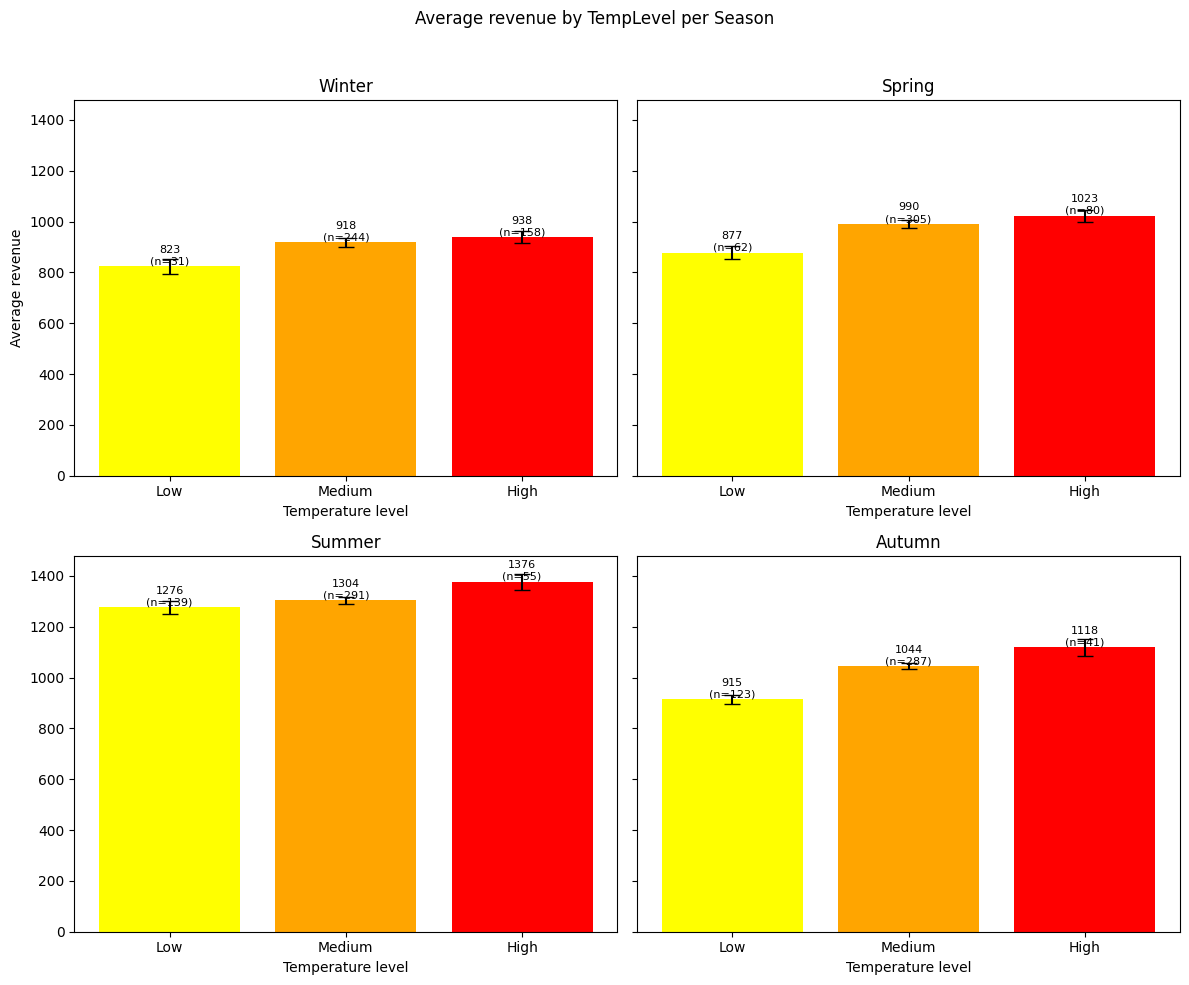

In [46]:
#FOURTH: CREATING GRAPHS TO VISUALIZE THE DATA

import numpy as np
import matplotlib.pyplot as plt

# ensure necessary columns
merged['Revenue'] = pd.to_numeric(merged.get('Revenue', merged.get('Umsatz')), errors='coerce')
merged['Season'] = merged['Season']  # assume Season exists
merged['TempLevel'] = merged['TempLevel']  # assume TempLevel exists

temp_order = ['low', 'medium', 'high']
seasons = ['Winter', 'Spring', 'Summer', 'Autumn']

fig, axes = plt.subplots(2, 2, figsize=(12, 10), sharey=True)

for i, season in enumerate(seasons):
    ax = axes.flat[i]
    df = merged[merged['Season'] == season]
    ax.set_title(season)
    if df.empty:
        ax.text(0.5, 0.5, 'No data', ha='center')
        continue

    stats = df.groupby('TempLevel')['Revenue'].agg(['mean', 'count', 'std']).reindex(temp_order)
    means = stats['mean'].fillna(0).values
    counts = stats['count'].fillna(0).astype(int).values
    sem = (stats['std'] / np.sqrt(stats['count'])).fillna(0).values

    x = np.arange(len(temp_order))
    ax.bar(x, means, yerr=sem, capsize=6, color=['yellow', 'orange', 'red'])
    ax.set_xticks(x)
    ax.set_xticklabels([t.capitalize() for t in temp_order])
    ax.set_xlabel('Temperature level')
    for xi, m, c in zip(x, means, counts):
        ax.text(xi, m, f'{m:.0f}\n(n={c})', ha='center', va='bottom', fontsize=8)
    
axes[0,0].set_ylabel('Average revenue')
plt.suptitle('Average revenue by TempLevel per Season')
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()



/var/folders/n8/b7lk16f91c514pclfv3qy2300000gn/T/ipykernel_22358/2120188153.py:20: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax.boxplot(data_to_plot, labels=labels, patch_artist=True)


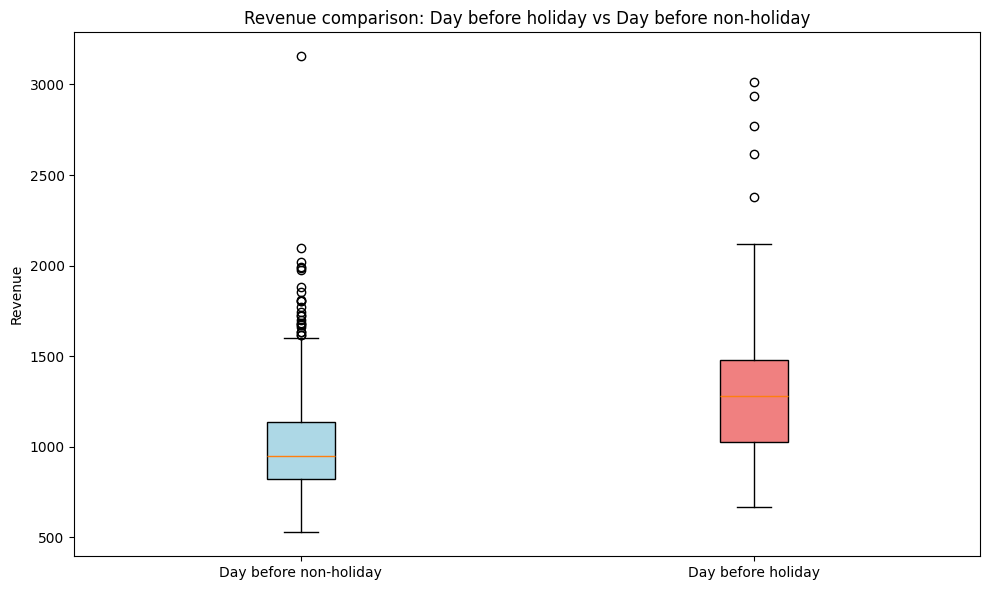

Day before non-holiday: mean=995.98, std=244.75
Day before holiday: mean=1272.47, std=324.85


In [47]:
# visualize differences in revenue: day before holiday vs day before non-holiday

merged['Date'] = pd.to_datetime(merged.get('Date', merged.get('Datum')))
merged['Revenue'] = pd.to_numeric(merged.get('Revenue', merged.get('Umsatz')), errors='coerce')
merged['HolidayFlag'] = merged.get('Holiday', merged.get('holiday'))

# shift holiday flag forward by 1 day to identify "day before holiday"
merged['NextDayHoliday'] = merged['HolidayFlag'].shift(-1)

# filter: day before a holiday vs day before a non-holiday
day_before_holiday = merged[merged['NextDayHoliday'] == 1]['Revenue']
day_before_non_holiday = merged[merged['NextDayHoliday'] == 0]['Revenue']

import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(10, 6))

data_to_plot = [day_before_non_holiday.dropna(), day_before_holiday.dropna()]
labels = ['Day before non-holiday', 'Day before holiday']

bp = ax.boxplot(data_to_plot, labels=labels, patch_artist=True)

# color boxes
for patch, color in zip(bp['boxes'], ['lightblue', 'lightcoral']):
    patch.set_facecolor(color)

ax.set_ylabel('Revenue')
ax.set_title('Revenue comparison: Day before holiday vs Day before non-holiday')
plt.tight_layout()
plt.show()

# print statistics
print(f"Day before non-holiday: mean={day_before_non_holiday.mean():.2f}, std={day_before_non_holiday.std():.2f}")
print(f"Day before holiday: mean={day_before_holiday.mean():.2f}, std={day_before_holiday.std():.2f}")